# Real or Not? NLP with Disaster Tweets

![](https://img3.goodfon.com/wallpaper/nbig/f/29/katastrofa-razrusheniya-zdaniya.jpg)

# 1. Import

In [1]:
# System
import os

# Time
import time
import datetime

# Numerical
import numpy as np
import pandas as pd
import random

# Tools
import itertools
from collections import Counter

# NLP
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from pywsd.utils import lemmatize_sentence

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential

# Deep Learning Model - Keras - CNN
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, \
    GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D 
from keras.layers.pooling import _GlobalPooling1D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.layers import MaxPooling3D, GlobalMaxPooling3D, GlobalAveragePooling3D



# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional

# Deep Learning Model - Keras - General
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply



# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Deep Learning Callbacs - Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print(os.listdir("../input"))

Using TensorFlow backend.


['nlp-getting-started']


In [2]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

# 2. Read Data

In [3]:
input_directory = r"../input/nlp-getting-started/"
output_directory = r"../output/"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory + r"/result"
file_name_pred_sample = figure_directory + r"/sample"

In [4]:
# Load data

df_train = pd.read_csv("../input/nlp-getting-started/train.csv")
df_test = pd.read_csv("../input/nlp-getting-started/test.csv")
sub_sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

print (df_train.shape, df_test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


# 3. Explorarory Data Analysis

Lets see first few columns of the dataset

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There are many null values in location and keyword

Following are the unique values of location and keyword

In [7]:
print (df_train.keyword.nunique(), df_train.location.nunique())
print (df_test.keyword.nunique(), df_test.location.nunique())

221 3341
221 1602


In [8]:
# Check if train and test have the same set of keywords
set(df_train.keyword.unique()) - set(df_test.keyword.unique())

set()

Lets see few tweet texts

In [9]:
c = 10
for i in range(c):
    r = random.randint(0, len(df_train)-1)
    r=i
    print(r," : ", df_train.iloc[r].text, "\n")

0  :  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

1  :  Forest fire near La Ronge Sask. Canada 

2  :  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 

3  :  13,000 people receive #wildfires evacuation orders in California  

4  :  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  

5  :  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 

6  :  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas 

7  :  I'm on top of the hill and I can see a fire in the woods... 

8  :  There's an emergency evacuation happening now in the building across the street 

9  :  I'm afraid that the tornado is coming to our area... 



In [10]:
columns = df_train.columns
columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## 3.2 Visualize Data

Number of tweets for disaster and non disaster in dataset

Text(0, 0.5, 'Count')

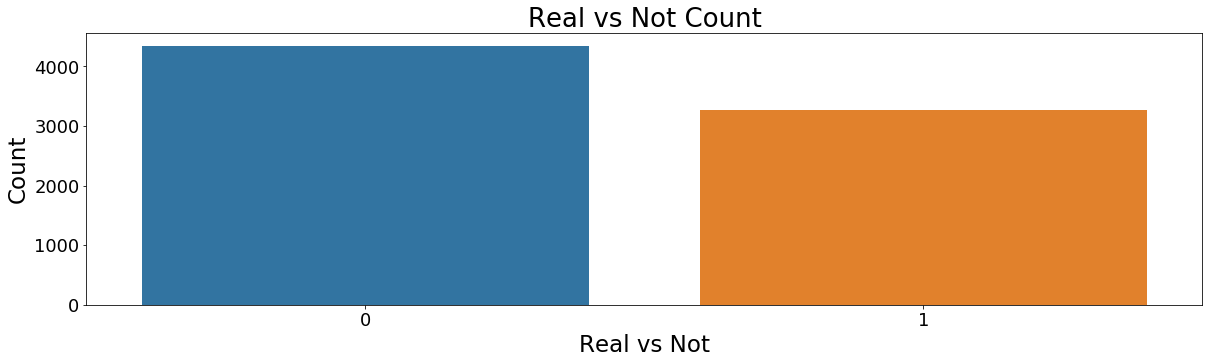

In [11]:
figsize=(20, 5)

ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col = "target"
xlabel = "Real vs Not"
ylabel = "Count"

sns.countplot(x=df_train[col])
plt.title("Real vs Not Count")
# plt.xticks(rotation=90)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Number of null values in feature columns

[]

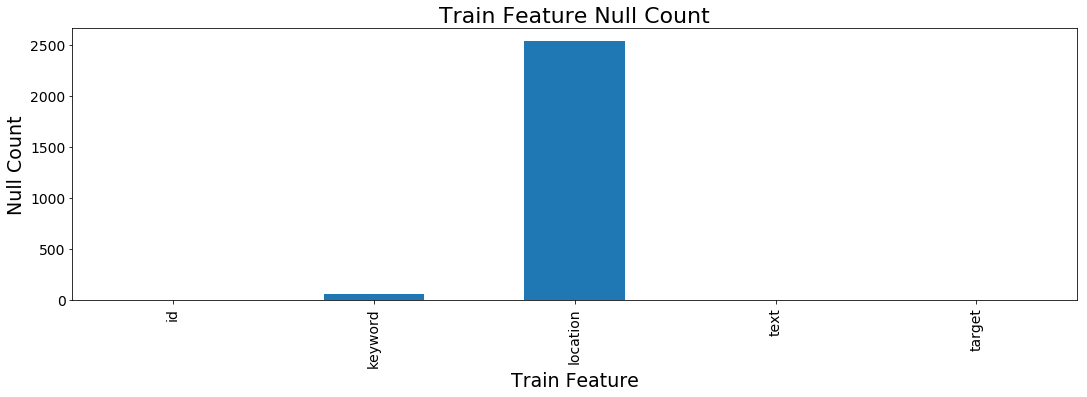

In [12]:
figsize=(18, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Train Feature"
ylabel = "Null Count"

title = "Train Feature Null Count"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

df_train.isnull().sum().plot(kind="bar")
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

[]

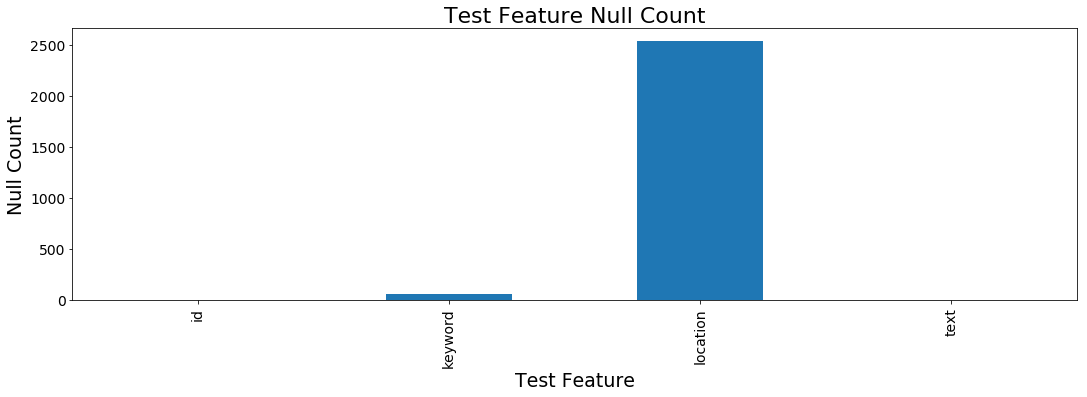

In [13]:
figsize=(18, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Test Feature"
ylabel = "Null Count"

title = "Test Feature Null Count"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

df_train.isnull().sum().plot(kind="bar")
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()


df_test.isnull().sum().plot(kind="bar")
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

Top keywords for tweets

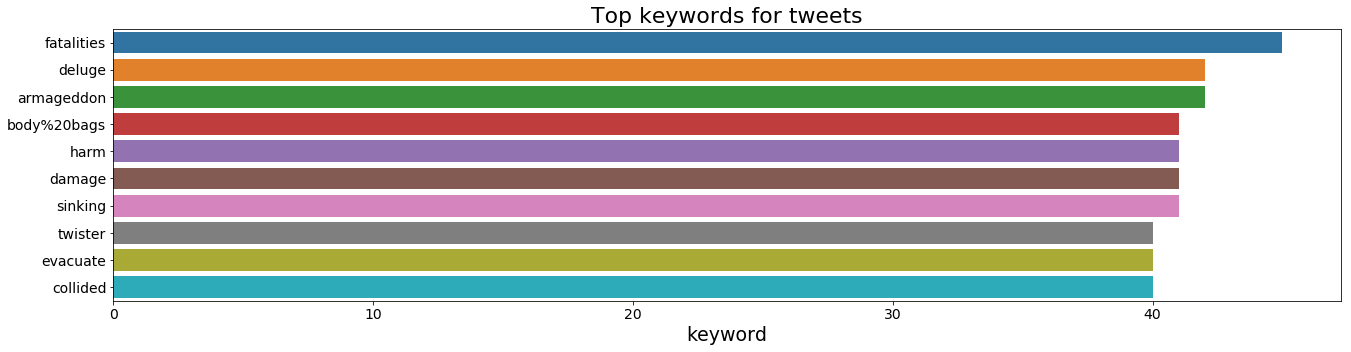

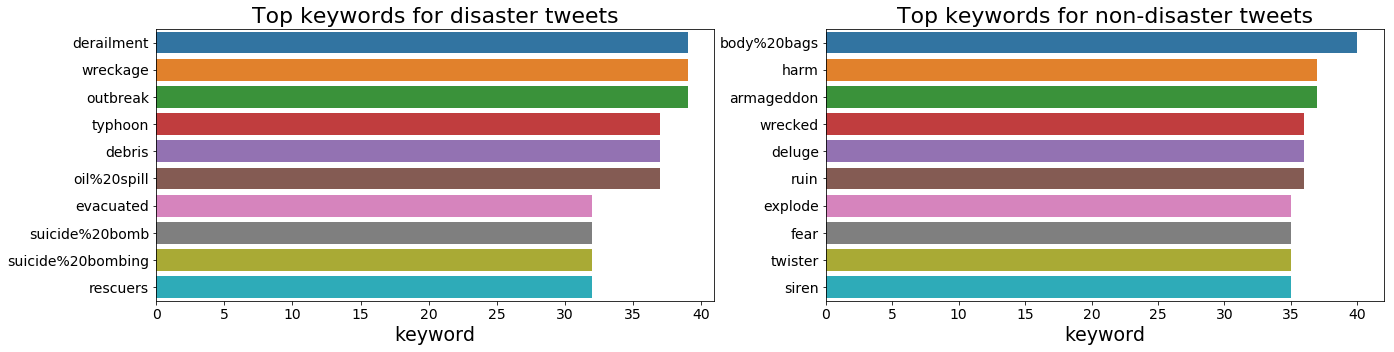

In [14]:
figsize=(22, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

# xlabel = "Train Feature"
# ylabel = "Null Count"

# title = "Train Feature Null Count"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

kw = df_train.keyword.value_counts().head(10)
kw_d = df_train[df_train.target==1].keyword.value_counts().head(10)
kw_nd = df_train[df_train.target==0].keyword.value_counts().head(10)

# plt.figure(figsize=(13,5))
sns.barplot(kw, kw.index)
plt.title('Top keywords for tweets')
plt.show()
plt.subplot(121)
sns.barplot(kw_d, kw_d.index)
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index)
plt.title('Top keywords for non-disaster tweets')
plt.show()

Top locations for tweets

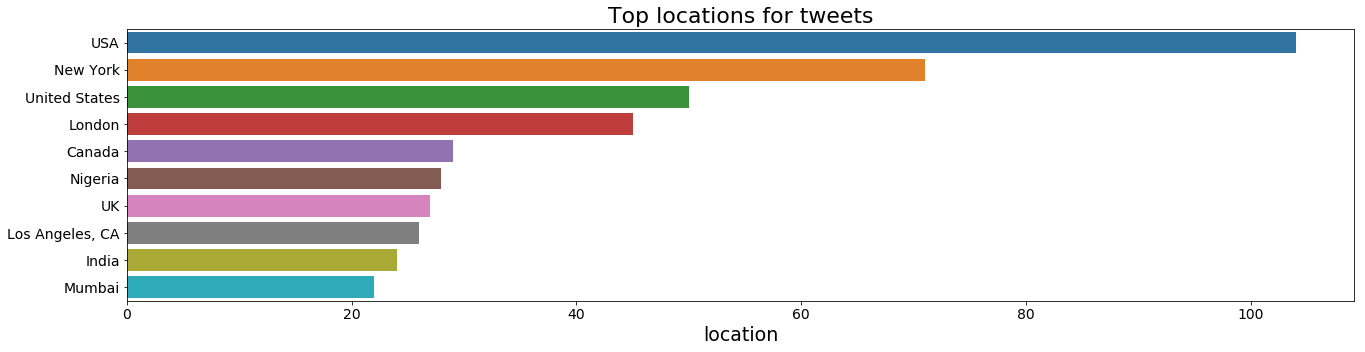

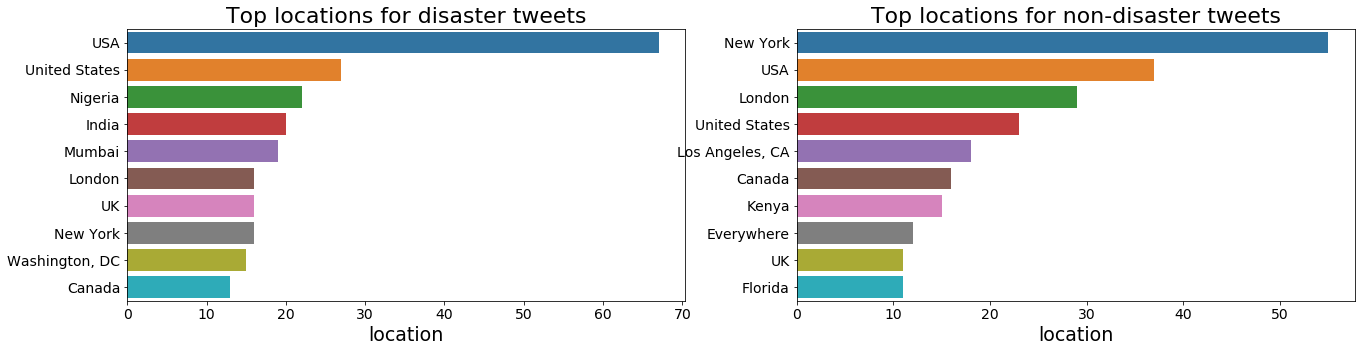

In [15]:
figsize=(22, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

# xlabel = "Train Feature"
# ylabel = "Null Count"

# title = "Train Feature Null Count"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

kw = df_train.location.value_counts().head(10)
kw_d = df_train[df_train.target==1].location.value_counts().head(10)
kw_nd = df_train[df_train.target==0].location.value_counts().head(10)

# plt.figure(figsize=(13,5))
sns.barplot(kw, kw.index)
plt.title('Top locations for tweets')
plt.show()
plt.subplot(121)
sns.barplot(kw_d, kw_d.index)
plt.title('Top locations for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index)
plt.title('Top locations for non-disaster tweets')
plt.show()

# 4. Feature Extraction

In [16]:
# Tweet length
df_train['text_len'] = df_train['text'].apply(len)
df_test['text_len'] = df_test['text'].apply(len)
# Word count
df_train["word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_test["word_count"] = df_test["text"].apply(lambda x: len(str(x).split()))
# Unique word count
df_train["unique_word_count"] = df_train["text"].apply(lambda x: len(set(str(x).split())))
df_test["unique_word_count"] = df_test["text"].apply(lambda x: len(set(str(x).split())))
# Count of hashtags (#)
df_train['hash_count'] = df_train['text'].apply(lambda x: str(x).count("#"))
df_test['hash_count'] = df_test['text'].apply(lambda x: str(x).count("#"))
# Count of mentions (@)
df_train['mention_count'] = df_train['text'].apply(lambda x: str(x).count("@"))
df_test['mention_count'] = df_test['text'].apply(lambda x: str(x).count("@"))

df_train.head()

,id,keyword,location,text,target,text_len,word_count,unique_word_count,hash_count,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,13,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,7,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,20,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,8,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,15,2,0


In [17]:
df_train = df_train[['id', 'keyword', 'location', 'text', 'text_len', 'word_count',
                     'unique_word_count', 'hash_count', 'mention_count', 'target']]
df_train.head()

,id,keyword,location,text,text_len,word_count,unique_word_count,hash_count,mention_count,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,69,13,13,1,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,38,7,7,0,0,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,133,22,20,0,0,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",65,8,8,1,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,88,16,15,2,0,1


Lets see

In [18]:
df_test.head()

,id,keyword,location,text,text_len,word_count,unique_word_count,hash_count,mention_count
0,0,NaN,NaN,Just happened a terrible car crash,34,6,6,0,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,9,9,1,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,19,19,0,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,4,4,2,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,8,8,0,0


In [19]:
# Tweet length
df_train['text_modified'] = df_train['text']
df_train['text_modified'] = df_train['text_modified'].apply(lambda x: re.sub(r"(%20)", r" ", x, flags=re.MULTILINE))
df_train['text_modified'] = df_train['text_modified'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', 'http://', x, flags=re.MULTILINE))
df_train['text_modified'] = df_train['text_modified'].apply(lambda x: re.sub(r"([^a-zA-Z1-9#])", r" \1 ", x, flags=re.MULTILINE))
df_train['text_modified'] = df_train['text_modified'].apply(lambda x: re.sub(r"\s+", " ", x, flags=re.MULTILINE))


df_train = df_train[['id', 'keyword', 'location', 'text', 'text_modified', 'text_len', 'word_count',
                     'unique_word_count', 'hash_count', 'mention_count', 'target']]
df_train.head()

,id,keyword,location,text,text_modified,text_len,word_count,unique_word_count,hash_count,mention_count,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,69,13,13,1,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask . Canada,38,7,7,0,0,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to ' shelter in place ' ar...,133,22,20,0,0,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13 , 0 0 0 people receive #wildfires evacuatio...",65,8,8,1,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,88,16,15,2,0,1


In [20]:
for i in range(10):
    r = random.randrange(len(df_train)-1)
    print(df_train.target[r], " : ", df_train.text_modified	[r])

0  :   @ Camilla _ 33 @ CrayKain Hate to shatter your delusions but a hatchet is a deadly weapon justifying lethal force . #gunsense
1  :  Thu Aug 0 6 2 0 15 0 1 : 2 0 : 32 GMT + 0 0 0 0 ( UTC ) #millcityio #2 0 15 0 613 theramin sirens
1  :   @ Bill _ Roose That looks so desolate and just . . . depressing
0  :   @ nprfreshair I really can ' t believe he is skipping out before the Republican meltdown . . . I mean ' debate ' . 
0  :   @ RaynbowAffair Editor In Chief @ DiamondKesawn Releases Issue #7 http : / / t . co / 7mzYcU2IHo of #RAmag . #Fashion #Models and #Mayhem
1  :  California man facing manslaughter charge in Sunday ' s wrong - way fatal crash in . . . - http : / / t . co / 1vz3RmjHy4 : Ca . . . http : / / t . co / xevUEEfQBZ
0  :  Yay for sirens
1  :  Udhampur terror attack : Militants attack police post 2 SPOs injured : Suspected militants tonight attacked a p . . . http : / / t . co / FPhFESemyJ
1  :  A Look at State Actions a Year After #Ferguson ' s Upheaval http : / / t

In [21]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:,'id':'mention_count'], df_train['target'], test_size=0.2, random_state=0)

## 4. Training Model

## 4.1 Gaussian Naive Bayes and TFIDF Vectorizer 

### 4.1.1 Original Text
Using Gassuan Naive Bayes, as machine learning algorithm and TFIDF vectorizer on original text

In [22]:
from sklearn.naive_bayes import GaussianNB

vectorizer = TfidfVectorizer(
#     input='content', 
#     encoding='utf-8', 
#     decode_error='strict', 
#     strip_accents=None, 
#     lowercase=False,
#     preprocessor=None,
#     tokenizer=None, 
#     analyzer='word',
    stop_words=None, 
    ngram_range=(1, 2), 
    max_df=0.6, 
    min_df=4, 
    max_features=None, 
#     vocabulary=None, 
#     binary=False, 
    norm='l2', 
    use_idf=True, 
    smooth_idf=True,
    sublinear_tf=True
)

X_train_tf = vectorizer.fit_transform(X_train.text.tolist()).toarray()
y_train = y_train

# print(train_X.shape)
# print(len(Y_train))


############################

gnb = GaussianNB()

X_test_tf = vectorizer.transform(X_test.text.tolist()).toarray()

y_pred = gnb.fit(X_train_tf, y_train).predict(X_test_tf)

print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Percentage of Correct points : %.2f" % (100-((y_test != y_pred).sum())/(len(y_test))*100))

Number of mislabeled points out of a total 1523 points : 359
Percentage of Correct points : 76.43


### 4.1.2 Modified Text
Using Gassuan Naive Bayes, as machine learning algorithm and TFIDF vectorizer on modified text

In [23]:
from sklearn.naive_bayes import GaussianNB

vectorizer = TfidfVectorizer(
#     input='content', 
#     encoding='utf-8', 
#     decode_error='strict', 
#     strip_accents=None, 
    lowercase=False,
#     preprocessor=None,
#     tokenizer=None, 
#     analyzer='word',
    stop_words=None, 
    ngram_range=(1, 2), 
    max_df=.6, 
    min_df=4, 
    max_features=None, 
#     vocabulary=None, 
#     binary=False, 
    norm='l2', 
    use_idf=True, 
    smooth_idf=True,
    sublinear_tf=True
)

X_train_tf = vectorizer.fit_transform(X_train.text_modified.tolist()).toarray()
y_train = y_train

# print(train_X.shape)
# print(len(Y_train))


############################

gnb = GaussianNB()

X_test_tf = vectorizer.transform(X_test.text_modified.tolist()).toarray()

y_pred = gnb.fit(X_train_tf, y_train).predict(X_test_tf)

print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Percentage of Correct points : %.2f" % (100-((y_test != y_pred).sum())/(len(y_test))*100))

Number of mislabeled points out of a total 1523 points : 379
Percentage of Correct points : 75.11


## 4.2 Logistic Regression of derived numerical features

In [24]:
# Most stupid model: Just to test submission
from sklearn.linear_model import LogisticRegression


X_train_at = X_train.loc[:,'text_len':'mention_count']
X_test_at = X_test.loc[:,'text_len':'mention_count']


model = LogisticRegression()
model.fit(X_train_at, y_train)
y_pred = model.predict(X_test_at)

from sklearn.metrics import f1_score
print('macro: ', f1_score(y_test, y_pred, average='macro'))
print('micro: ', f1_score(y_test, y_pred, average='micro'))
print('weighted: ', f1_score(y_test, y_pred, average='weighted'))
print('None: ', f1_score(y_test, y_pred, average=None))
# f1_score(y_test, y_pred, zero_division=1)

macro:  0.5968089777364534
micro:  0.6231122783978988
weighted:  0.6136457948693581
None:  [0.69979079 0.49382716]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 4.3. Deep Learning

### 4.3.1 Output Configuration

In [25]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

### 4.3.2 Callback Settings

In [26]:
print("Settting Callbacks")

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1)


# callbacks = [checkpoint, reduce_lr, early_stopping]

callbacks = [reduce_lr, early_stopping]

print("Set Callbacks at ", date_time(1))

Settting Callbacks
Set Callbacks at  Timestamp: 2020-01-30 08:14:01


### 4.3.3. Preprocessing

In [27]:
# Calculate Class Weights
def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [28]:
X = df_train.text
Y = df_train.target

label_encoder = LabelEncoder()

Y = label_encoder.fit_transform(Y)
print(Y)
Y = to_categorical(Y)
print(Y)
# Y = Y.reshape(-1, 1)
Y

[1 1 1 ... 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()

# max_words = 1000
# max_len = 150
max_words, max_len

(28366, 157)

In [30]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)

In [31]:
class_weight = get_weight(np.argmax(Y_train ,axis=1))
class_weight

array([0.87540584, 1.16594595])

### 4.3.4. Model

In [32]:
# def get_rnn_model(num_class=2):
#     model = Sequential()
    
#     model.add(Embedding(max_words, 100, input_length=max_len))
#     model.add(LSTM(256))
    
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
#     model.add(Dense(512, activation='relu'))
    
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
#     if num_class>=2:
#         model.add(Dense(num_class, activation='softmax'))
#     else:
#         model.add(Dense(1, activation='sigmoid'))
    
#     model.summary()
    
#     return model

def get_rnn_model(num_class=2):
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    if num_class>=2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model


def get_cnn_model(num_class=2):   
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    
    model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2048, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    if num_class>=2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    return model

In [33]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

#     ylim_pad = [0.1, 0.005]
    ylim_pad = [0, 0.5]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
    min_y = 0
    max_y = 1


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

#     min_y = 0
#     max_y = .8

    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [34]:
num_class = 2
model1 = get_rnn_model(num_class=num_class)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 157, 100)          2836600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 157, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               731136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)              

In [35]:
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['accuracy']

### 4.3.5 Model Trainning

#### 4.3.5.1 RNN

In [36]:
print("Starting...\n")

start_time = time.time()
print(date_time(1))

print("\n\nCompliling Model ...\n")
learning_rate = 0.0001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 100
batch_size = 16
validation_split = 0.2

print("Trainning Model ...\n")

history1 = model1.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_split=validation_split,
    class_weight=class_weight
    )

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

Starting...

Timestamp: 2020-01-30 08:14:06


Compliling Model ...

Trainning Model ...



/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5176 samples, validate on 1295 samples
Epoch 1/100
5176/5176 [==============================] - 96s 19ms/step - loss: 0.6403 - accuracy: 0.6285 - val_loss: 0.6457 - val_accuracy: 0.5807
Epoch 2/100
5176/5176 [==============================] - 94s 18ms/step - loss: 0.4553 - accuracy: 0.7960 - val_loss: 0.4862 - val_accuracy: 0.7792
Epoch 3/100
5176/5176 [==============================] - 94s 18ms/step - loss: 0.3238 - accuracy: 0.8644 - val_loss: 0.5362 - val_accuracy: 0.7776
Epoch 4/100
5176/5176 [==============================] - 94s 18ms/step - loss: 0.2323 - accuracy: 0.9042 - val_loss: 0.7195 - val_accuracy: 0.7575

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/100
5176/5176 [==============================] - 94s 18ms/step - loss: 0.1582 - accuracy: 0.9397 - val_loss: 0.8979 - val_accuracy: 0.6903
Epoch 6/100
5176/5176 [==============================] - 94s 18ms/step - loss: 0.1274 - accuracy: 0.9507 - val_loss: 0.8110 - val_accura

##### 4.3.5.1.2  Visualization

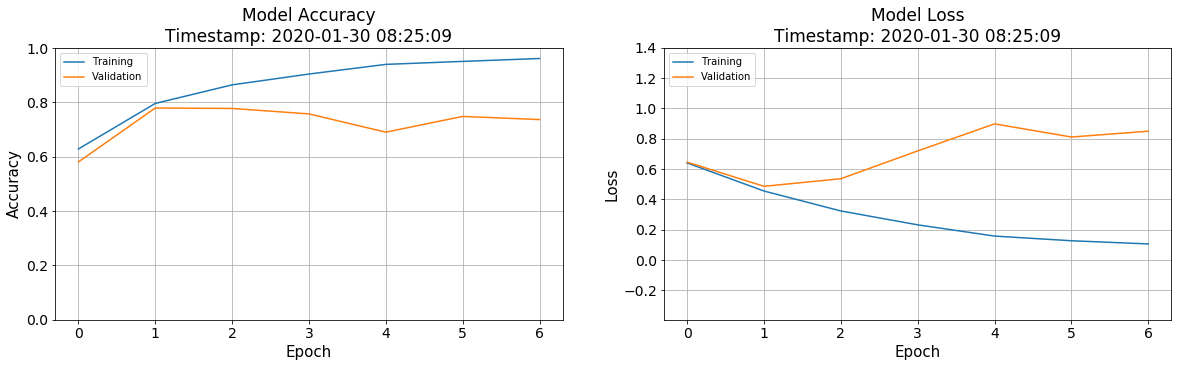

In [37]:
plot_performance(history=history1)

#### 4.3.5.2. CNN

In [38]:
num_class = 2
model2 = get_cnn_model(num_class=num_class)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 157, 100)          2836600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 155, 1024)         308224    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)             

In [39]:
print("Starting...\n")

start_time = time.time()
print(date_time(1))

print("\n\nCompliling Model ...\n")
learning_rate = 0.0001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 100
batch_size = 16
validation_split = 0.2

print("Trainning Model ...\n")

history2 = model2.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_split=validation_split,
    class_weight =class_weight
    )

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

Starting...

Timestamp: 2020-01-30 08:25:10


Compliling Model ...

Trainning Model ...



/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5176 samples, validate on 1295 samples
Epoch 1/100
5176/5176 [==============================] - 7s 1ms/step - loss: 1.2181 - accuracy: 0.5189 - val_loss: 0.7872 - val_accuracy: 0.4270
Epoch 2/100
5176/5176 [==============================] - 3s 574us/step - loss: 1.1197 - accuracy: 0.5526 - val_loss: 0.7037 - val_accuracy: 0.5784
Epoch 3/100
5176/5176 [==============================] - 3s 580us/step - loss: 1.0146 - accuracy: 0.5767 - val_loss: 0.6748 - val_accuracy: 0.6255
Epoch 4/100
5176/5176 [==============================] - 3s 579us/step - loss: 0.9761 - accuracy: 0.5852 - val_loss: 0.6368 - val_accuracy: 0.6394
Epoch 5/100
5176/5176 [==============================] - 3s 571us/step - loss: 0.8764 - accuracy: 0.6086 - val_loss: 0.6256 - val_accuracy: 0.6425
Epoch 6/100
5176/5176 [==============================] - 3s 565us/step - loss: 0.8392 - accuracy: 0.6190 - val_loss: 0.6117 - val_accuracy: 0.6502
Epoch 7/100
5176/5176 [==============================] - 3s 592us/step -

#### 4.3.5.2.2 Visualization

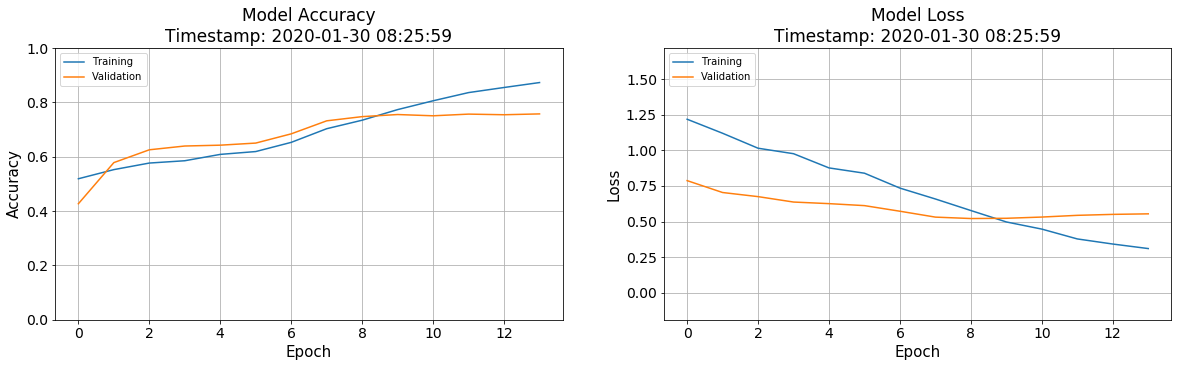

In [40]:
plot_performance(history=history2)

### 14.3.6 Inference/ Prediction

In [41]:
test_X_seq = tokenizer.texts_to_sequences(X_test)
test_X_seq = sequence.pad_sequences(test_X_seq, maxlen=max_len)
accuracy1 = model1.evaluate(test_X_seq, Y_test)
accuracy2 = model2.evaluate(test_X_seq, Y_test)

1142/1142 [==============================] - 0s 108us/step


### 4.3.7 Evaluation

In [42]:
print("Model Performance of RNN (Test Accuracy):")
print('Accuracy: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy1[1]*100, accuracy1[0]))

print("\nModel Performance of RNN (Test Accuracy):")
print('v: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy2[1]*100, accuracy2[0]))

Model Performance of RNN (Test Accuracy):
Accuracy: 79.16%
Loss: 0.479


Model Performance of RNN (Test Accuracy):
v: 76.01%
Loss: 0.486



In [43]:
ypreds1 = model1.predict_classes(test_X_seq, verbose=1)
ypreds2 = model2.predict_classes(test_X_seq, verbose=1)

1142/1142 [==============================] - 0s 144us/step


In [44]:
def plot_model_performace(result):
    sns.set_style("ticks")
    figsize=(22, 6)

    ticksize = 12
    titlesize = ticksize + 8
    labelsize = ticksize + 5

    xlabel = "Model"
    ylabel = "Score"

    title = "Model Performance"

    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)

    col1 = "model"
    col2 = "score"
    sns.barplot(x=col1, y=col2, data=result)
    plt.title(title.title())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.grid()
    plt.plot()
    plt.show()
    print(result)

In [45]:
# print(classification_report(Y_test, ypreds1))

In [46]:
# plot_confusion_matrix(Y_test, ypreds1, title="RNN")

In [47]:
# print(classification_report(Y_test, ypreds2))

#### 10.5.1.2 Visualization

In [48]:
# plot_confusion_matrix(Y_test, ypreds2, title="CNN")

In [49]:
result = pd.DataFrame({'model': 'RNN', 'score': accuracy1[1]*100}, index=[-1])
row2 = pd.DataFrame({'model': 'CNN', 'score': accuracy2[1]*100}, index=[-1])
result = pd.concat([row2, result.ix[:]]).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


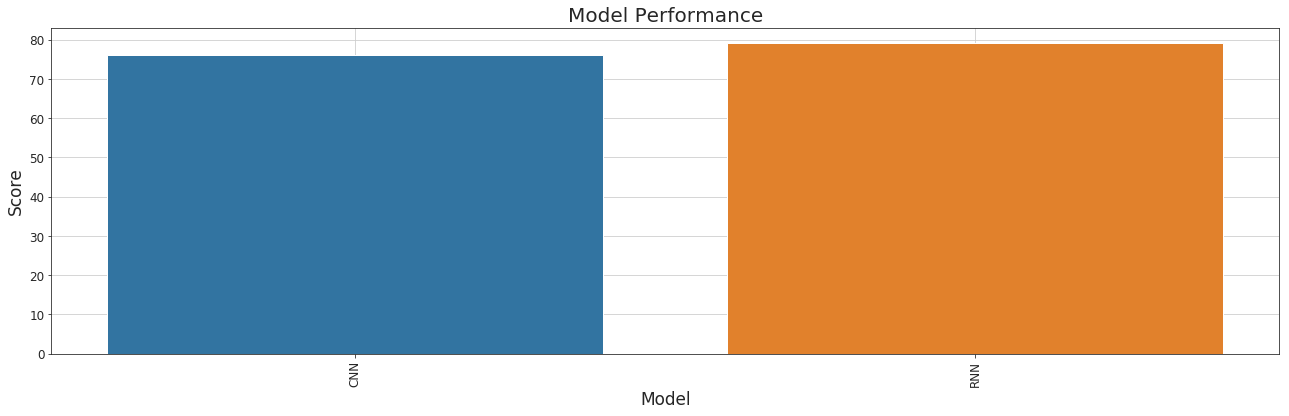

  model      score
0   CNN  76.007003
1   RNN  79.159367


In [50]:
plot_model_performace(result)

# Final

In [51]:
df_train.head()

,id,keyword,location,text,text_modified,text_len,word_count,unique_word_count,hash_count,mention_count,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,69,13,13,1,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask . Canada,38,7,7,0,0,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to ' shelter in place ' ar...,133,22,20,0,0,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13 , 0 0 0 people receive #wildfires evacuatio...",65,8,8,1,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,88,16,15,2,0,1


In [52]:
from sklearn.naive_bayes import GaussianNB

vectorizer = TfidfVectorizer(
#     input='content', 
#     encoding='utf-8', 
#     decode_error='strict', 
#     strip_accents=None, 
#     lowercase=False,
#     preprocessor=None,
#     tokenizer=None, 
#     analyzer='word',
    stop_words=None, 
    ngram_range=(1, 2), 
    max_df=0.6, 
    min_df=4, 
    max_features=None, 
#     vocabulary=None, 
#     binary=False, 
    norm='l2', 
    use_idf=True, 
    smooth_idf=True,
    sublinear_tf=True
)

X_train_tf = vectorizer.fit_transform(df_train.text.tolist()).toarray()

y_train = df_train.target.tolist()

# print(train_X.shape)
# print(len(Y_train))


############################

gnb = GaussianNB()

X_test_tf = vectorizer.transform(df_test.text.tolist()).toarray()

y_pred = gnb.fit(X_train_tf, y_train).predict(X_test_tf)

In [53]:
df_test.head()

,id,keyword,location,text,text_len,word_count,unique_word_count,hash_count,mention_count
0,0,NaN,NaN,Just happened a terrible car crash,34,6,6,0,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,9,9,1,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,19,19,0,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,4,4,2,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,8,8,0,0


In [54]:
sample_list = list(sub_sample.id)

pred_dict = dict((key, value) for (key, value) in zip(df_test.id, y_pred))

pred_list_new = [pred_dict[f] for f in sample_list]

test_df = pd.DataFrame({'id': sample_list, 'target': pred_list_new})

test_df.to_csv("submission.csv", header=True, index=False)